## Wprowadzenie
Skrypt pokazuje jak użyć pakietu SciKit do grupowania danych. Rozważane są dwa przykłady: dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich oraz dane IRIS.

In [1]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sklearn

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [47]:
import matplotlib.colors as colors
from itertools import cycle

def plotClustering(X, plt_labels, roots=None, p =20):
    plt_colors = cycle(colors.cnames.keys())
    
    plt_K = np.unique(plt_labels).size
    
    if -1 in plt_labels:
        plt_labels = plt_labels +1
    for k in xrange(plt_K):
        color = plt_colors.next()
        mask = (plt_labels == k)
        plt.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=color, marker='o')
        if roots != None and len(roots) > k:    
            plt.plot(roots[k, 0], roots[k, 1], 'w', markersize=p, markerfacecolor=color, marker='o')
    plt.show()

def normalize(X):
    mins = np.min(X, 0)
    maxs = np.max(X, 0)
    #print mins, maxs
    return (X-mins)/(maxs-mins)

def standarize(X):
    means = np.mean(X, 0)
    stds = np.std(X, 0)
    print 'mean: ', means
    print 'stds: ', stds
    return (X-means)/stds

    
def dunn_index(X, labels):
    clusters = [X[labels == c] for c in np.unique(labels)]
    #srednia odleglosc pomiedzy punktami w klastrze
    max_c = np.max([np.mean(np.sqrt(np.sum((c[:, np.newaxis] - c)**2, -1).T)) for c in clusters])
    centers = np.array([np.mean(cluster, 0) for cluster in clusters if len(cluster) >0])
    centers_dist = np.sqrt(np.sum((centers[:, np.newaxis] - centers)**2, -1))
    #odleglosc pomiedzy klastrami
    min_dist = centers_dist[centers_dist >0].min()
    #im mniej tym lepiej
    return(min_dist/max_c)
    
def davisBouldin(X, labels, p=2):
    clusters = [X[labels == c] for c in np.unique(labels)]
    centers = np.array([np.mean(cluster, 0) for cluster in clusters if len(cluster) >0])
    centers_dist = np.power(np.sum((centers[:, np.newaxis] - centers)**2, -1), 1./2)
    #odleglosc punktow od centrow dla klastrow
    s_i = np.array([ np.power(np.sum(np.mean((cluster - center)**p, 0)), 1./p) for cluster,center in zip(clusters,centers)])
    #promien klastra + promien klastra / odległośc pomiecdzy klastrami
    measure = (s_i[:,np.newaxis] + s_i) / centers_dist
    #print s_i
    #print centers_dist
    np.fill_diagonal(measure, 0)
    #print measure
    return np.mean(np.max(measure, 0))
    

def score(X, labels):
    return [sklearn.metrics.silhouette_score(X, labels),
            dunn_index(X, labels),
            davisBouldin(X, labels)]

def print_hist(x, b= 10, label = "default"):
    hist, bins = np.histogram(x, bins=b)
    center = (bins[:-1] + bins[1:]) / 2
    w = 1.*(np.amax(x) - np.amin(x))/b
    
    plt.bar(center, hist, align='center', width=w)
    plt.title(label)
    plt.show()

print davisBouldin(np.array([[2,2], [3,3], [3,3], [4,4]]), np.array([0, 0, 1, 2]))
print 'TEST ', dunn_index(np.array([[2,2], [3,3], [3,3], [4,4]]), np.array([0, 0, 1, 2])), 1

0.777777777778
TEST  1.0 1


## 1. Pierwszy zestaw danych
Dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich

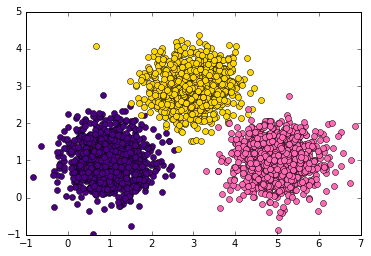

In [6]:
from sklearn import datasets

centers_ = [[1, 1], [3, 3], [5, 1]]
X, labels = datasets.make_blobs(n_samples=3000, n_features=2, centers=centers_, cluster_std=0.5)

plotClustering(X, labels)

### Grupowanie za pomocą KMeans

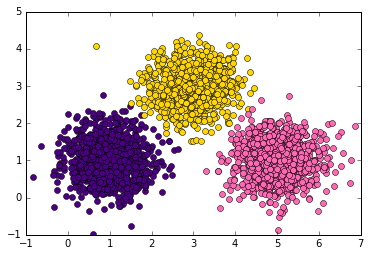

[0.668597592481601, 3.0422512890429614, 0.50803383663806434]

In [7]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=1)
k_means.fit(X)

plotClustering(X, k_means.labels_)
score(X, k_means.labels_)

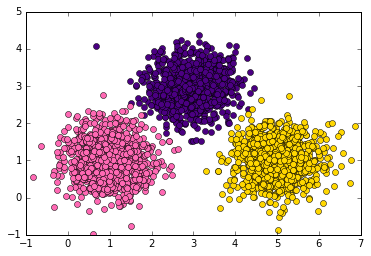

In [8]:
#1
#a
k_means = KMeans(init='k-means++', n_clusters=3, n_init=20)
k_means.fit(X)
plotClustering(X, k_means.labels_)
#Number of time the k-means algorithm will be run with different centroid seeds. 
#The final results will be the best output of n_init consecutive runs in terms of inertia.


### Grupowanie za pomocą MiniBatchKMeans

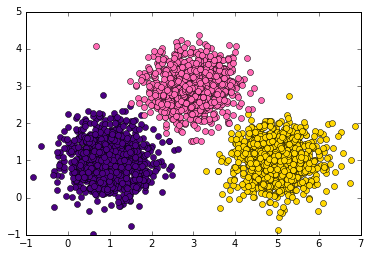

In [9]:
mini_batch_k_means = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=100, n_init=1, max_no_improvement=10, verbose=0, random_state=0)
mini_batch_k_means.fit(X)

plotClustering(X, mini_batch_k_means.labels_)

### Grupowanie za pomocą Birch bez wtórnego grupowania

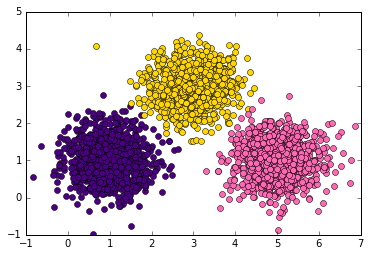

(102, 2) (102,)
[[ 2.72357919  2.94254422]
 [ 4.71374622  1.39121683]
 [ 0.9728469   0.98274056]]


/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


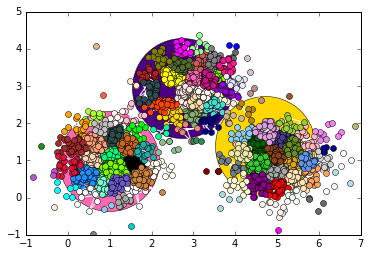

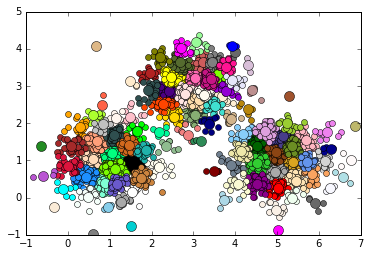

In [48]:
birch = Birch(threshold=1,n_clusters=None)
birch.fit(X)
#b
#Prog dla jakiego tworzony jest nowy lisc (jeśli znajdzie się klasa c ze d(x1, c)) dla punktu x1, to x1 trafia do c
plotClustering(X, birch.labels_)
#2a,b,c
birch = Birch(threshold=0.25,n_clusters=None)
birch.fit(X)
print birch.subcluster_centers_.shape, np.unique(birch.labels_).shape
print birch.root_.centroids_
plotClustering(X, birch.labels_, birch.root_.centroids_, 100)
plotClustering(X, birch.labels_, birch.subcluster_centers_, 10)

### Grupowanie za pomocą Birch z wtórnym grupowaniem

data:  (1000, 2)
lab:  (1000,)


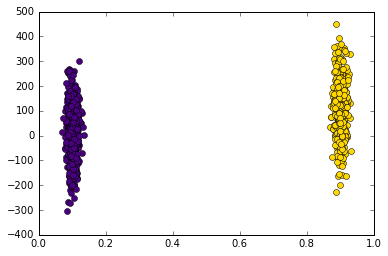

mean:  [  0.50059536  55.45827736]
stds:  [   0.40047231  114.41614115]


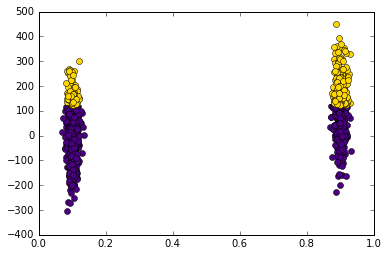

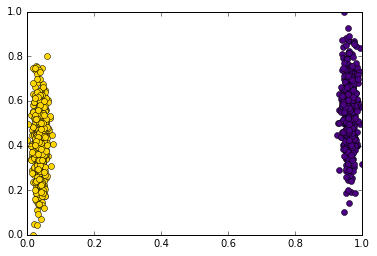

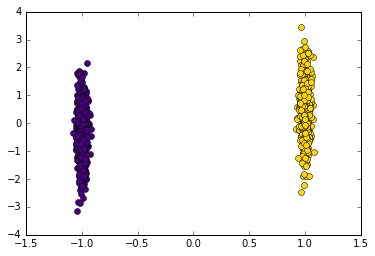

In [150]:
data_2, labels_2 = datasets.make_blobs(n_samples=1000, n_features=2, centers=[[0.1, 1], [0.9, 99]], cluster_std=[[0.01, 100], [0.01, 100]])
print 'data: ', data_2.shape
print 'lab: ', labels_2.shape
plotClustering(data_2, labels_2)
X_s = standarize(data_2)
X_n = normalize(data_2)

birch = Birch(threshold=0.75, n_clusters=2)

birch.fit(data_2)
plotClustering(data_2, birch.labels_)

birch = Birch(threshold=0.1, n_clusters=2)
birch.fit(X_n)
plotClustering(X_n, birch.labels_)

birch = Birch(threshold=0.75, n_clusters=2)
birch.fit(X_s)
plotClustering(X_s, birch.labels_)

### Grupowanie za pomocą DBScan

In [5]:
dbscan = DBSCAN(eps=0.2, min_samples=25)
dbscan.fit(X)

print X.shape, dbscan.labels_.shape
plotClustering(X, dbscan.labels_)

NameError: name 'X' is not defined

## 2. Drugi zestaw danych
Dane IRIS

In [132]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data

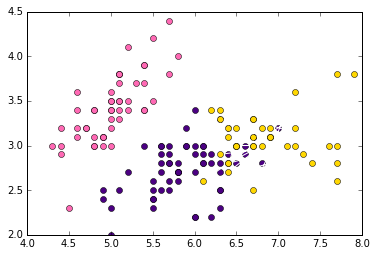

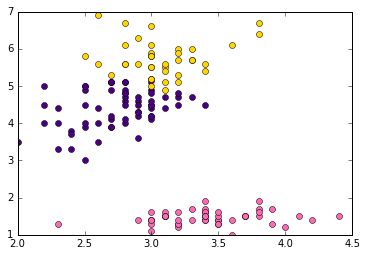

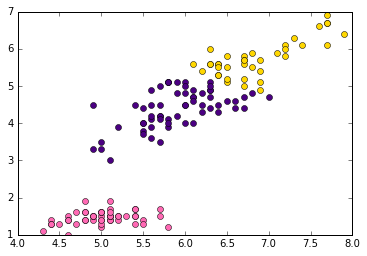

In [146]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=1)
k_means.fit(X)

plotClustering(X[:, :2], k_means.labels_)
plotClustering(X[:, 1:], k_means.labels_)
plotClustering(X[:, [0,2]], k_means.labels_)


In [147]:
score(X, k_means.labels_)

0.55259194452136762

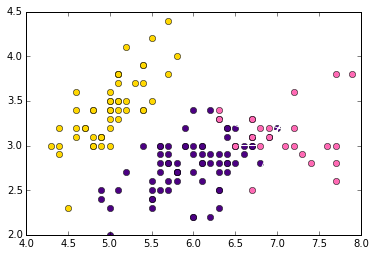

In [11]:
birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)

plotClustering(X[:, :2], birch.labels_)

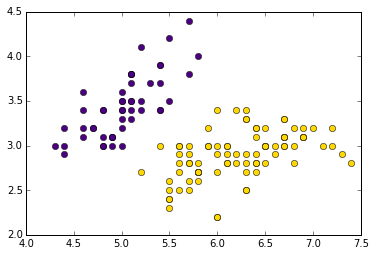

In [12]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)

plotClustering(X[:, :2], dbscan.labels_)